## Check the impact of the scaling factors

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from typing import Any

In [14]:
def get_scaling(
    price: pd.Series, t: list
) -> tuple[np.ndarray[float, Any], np.ndarray[float, Any], np.ndarray[float, Any]]:
    """Compute scaling function

    Args:
        price (pd.Series): original data
        t (list): scale values

    Returns:
        tuple[np.ndarray[float, Any], np.ndarray[float, Any], np.ndarray[float, Any]]: Taus, Cs, qs
    """

    q = np.linspace(0.01, 10.01, 1_000)
    tau = np.zeros_like(q)
    c = np.zeros_like(q)
    n = len(price)
    log_prices = np.log(price.values)
    delta = np.log(t)
    log_n = np.log(n)
    # Partiton function
    for r, qq in enumerate(q):
        y = np.zeros(len(t))
        for s, tt in enumerate(t):
            x = np.arange(0, n, tt)
            log_price_diff = np.diff(log_prices[x])
            y[s] = np.log(np.sum(np.abs(log_price_diff) ** qq)) - log_n
        # Estimate tau with linear regression
        lm_result = np.polyfit(delta, y, 1)
        tau[r] = lm_result[0]
        c[r] = lm_result[1]
    tau = np.concatenate(([-1], tau))
    q = np.concatenate(([0], q))
    c = np.concatenate(([1], c))
    return tau, c, q

In [15]:
def divisors(n: int) -> np.ndarray[int, Any]:
    """Compute divisors

    Args:
        n (int): number to compute divisors

    Returns:
        np.ndarray[int]: divisors
    """
    divs = [1]
    for i in range(2, int(np.sqrt(n)) + 1):
        if n % i == 0:
            divs.extend([i, int(n / i)])
    divs.extend([n])
    return np.array(sorted(set(divs)))[:-2]

In [16]:
spy = pd.read_csv("../data/raw/spy.csv", parse_dates=True, index_col=0)
spy = spy.loc[:"2018-01-02",]
spy

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2005-01-03,121.559998,121.760002,119.900002,120.300003,83.623352,55748000
2005-01-04,120.459999,120.540001,118.440002,118.830002,82.601585,69167600
2005-01-05,118.739998,119.250000,118.000000,118.010002,82.031548,65667300
2005-01-06,118.440002,119.150002,118.260002,118.610001,82.448624,47814700
2005-01-07,118.970001,119.230003,118.129997,118.440002,82.330460,55847700
...,...,...,...,...,...,...
2017-12-26,267.049988,267.440002,266.890015,267.190002,241.643372,45244400
2017-12-27,267.380005,267.730011,267.010010,267.320007,241.760895,57751000
2017-12-28,267.890015,267.920013,267.450012,267.869995,242.258301,45116100


In [17]:
wk_df = spy.iloc[:-1,]["Close"]

In [22]:
len(wk_df)

3272

In [34]:
tau_r, c, q = get_scaling(wk_df, t=[2, 3, 4, 5, 10, 15, 20])

In [37]:
tau_r_mod, c, q = get_scaling(wk_df, t=[2, 3, 4, 5, 10, 15, 20, 50, 100, 300])

In [31]:
tau_div, _, _ = get_scaling(wk_df, t=divisors(len(wk_df)))

In [32]:
tau_time, _, _ = get_scaling(wk_df, t=[1, 5, 10, 15, 21, 63, 126, 252])

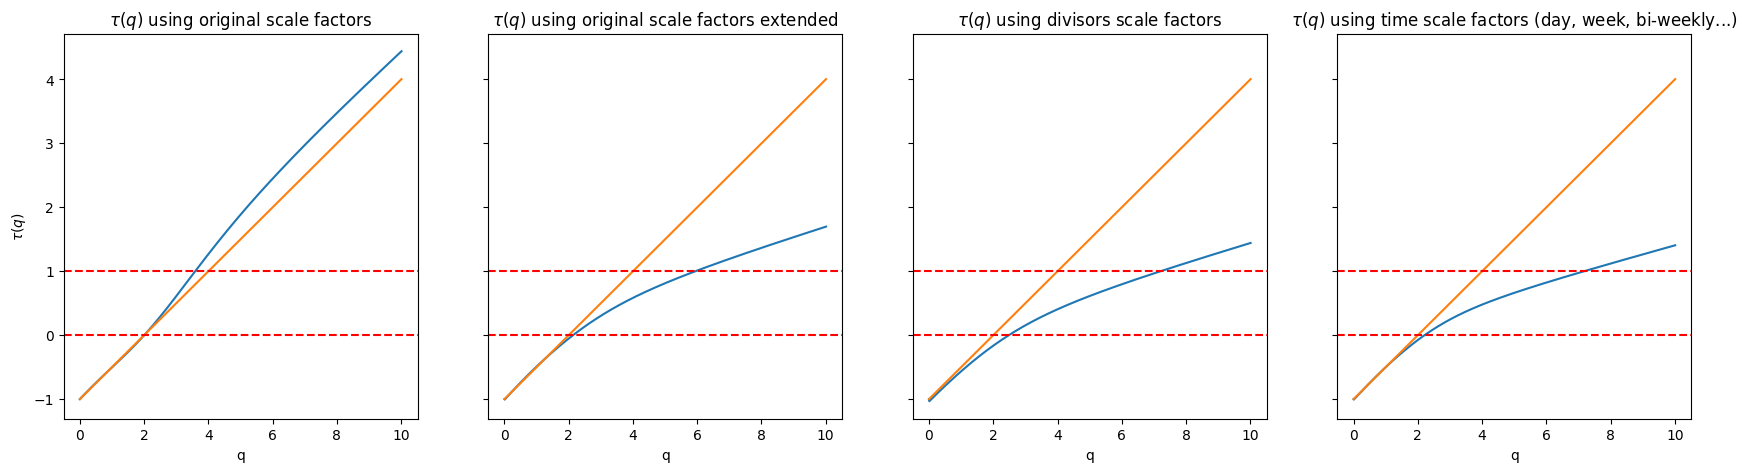

In [40]:
fig, ax = plt.subplots(1, 4, figsize=(21, 5), sharex=True, sharey=True)
ax[0].plot(q, tau_r)
ax[0].plot(q, q / 2 - 1)
ax[0].axhline(0, c="r", ls="--")
ax[0].axhline(1, c="r", ls="--")
ax[0].set_title(r"$\tau(q)$ using original scale factors")
ax[0].set_xlabel("q")
ax[0].set_ylabel(r"$\tau(q)$")

ax[1].plot(q, tau_r_mod)
ax[1].plot(q, q / 2 - 1)
ax[1].axhline(0, c="r", ls="--")
ax[1].axhline(1, c="r", ls="--")
ax[1].set_title(r"$\tau(q)$ using original scale factors extended")
ax[1].set_xlabel("q")

ax[2].plot(q, tau_div)
ax[2].plot(q, q / 2 - 1)
ax[2].axhline(0, c="r", ls="--")
ax[2].axhline(1, c="r", ls="--")
ax[2].set_title(r"$\tau(q)$ using divisors scale factors")
ax[2].set_xlabel("q")

ax[3].plot(q, tau_time)
ax[3].plot(q, q / 2 - 1)
ax[3].axhline(0, c="r", ls="--")
ax[3].axhline(1, c="r", ls="--")
ax[3].set_title(r"$\tau(q)$ using time scale factors (day, week, bi-weekly...)")
ax[3].set_xlabel("q")
plt.show()

It seems clear that the arbitrary scale factor choice used in  the original paper was suitable for the original time frame, but totaly unfit in our case. Extending the original choice by adding bigger divisors, instead, gives reasonable results. Using divisors or arbirtary time scaling factors (from day to year), give close but differtent results.